Import Libraries:

In [1]:
%matplotlib inline
# %matplotlib notebook
from sklearn.model_selection import train_test_split
import numpy as np
import qutip as qt
from sklearn.manifold import TSNE
from vae import * 

2023-03-24 10:35:41.706105: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 10:35:41.898417: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-24 10:35:41.911673: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-24 10:35:41.911688: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

# Noiseless Dataset

Load Dataset

In [2]:
n_angle = 101
n_samples = 1000
rho_arr = np.load('unitary_4x4_101_1000_noiseless.npy', mmap_mode="r")
scan_arr = np.linspace(0, np.pi, n_angle)

alpha_arr = np.zeros(len(rho_arr))
cnt = 0
for theta in scan_arr:
        for _ in (range(n_samples)):
            alpha_arr[cnt] = theta
            cnt += 1


X_train, X_test, y_train, y_test = train_test_split(rho_arr, alpha_arr, random_state=42)
concurrence_arr = np.array([qt.concurrence(qt.Qobj(dm.reshape(4,4),dims=[[2,2],[2,2]])) for dm in X_test])

Define Hyperparameters:

In [3]:
batch_size = 64
beta = 0.0
learning_rate = 0.005
lat_dim = 1
hidden_act = "relu"
final_act = "tanh"

Load trained VAE:

In [4]:
encoder, decoder = vae_mlp_4x4(lat_dim, hidden_act, final_act)

encoder.load_weights("encoder_noiseless.h5")
decoder.load_weights("decoder_noiseless.h5")

vae = VAE(encoder, decoder, beta)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
vae.fit(X_test, epochs=1, batch_size=64, verbose=1) 

z_mean, z_log_var, z = vae.encoder.predict(X_test)

2023-03-08 18:45:05.789664: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-08 18:45:05.789681: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-08 18:45:05.789695: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (felix-Latitude-5521): /proc/driver/nvidia/version does not exist
2023-03-08 18:45:05.789837: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


790/790 [==============================] - 0s 421us/step


Investigate Latent Space

In [140]:
fig_size_dim    = 4
golden_ratio    = (1+np.sqrt(5))/2
fig_size        = (fig_size_dim, fig_size_dim/golden_ratio)

def plot_style():
    font_size       = 12
    dpi             = 200

    params = {'figure.figsize': fig_size,
              'figure.dpi': dpi,
              'savefig.dpi': dpi,
              'font.size': font_size,
              'font.family': "sans-serif",
              'font.sans-serif': ["Helvetica"],
              'figure.titlesize': font_size,
              'legend.fontsize': font_size,
              'axes.labelsize': font_size,
              'axes.titlesize': font_size,
              'xtick.labelsize': font_size,
              'ytick.labelsize': font_size,
              'text.usetex': True,
             }

    plt.rcParams.update(params)
plot_style()

In [141]:
fig, ax = plt.subplots(figsize=(4, 3),dpi=150)

sort_inx = np.argsort(y_test)

ax.plot(y_test[sort_inx][::1000], (z_mean[sort_inx][:,0][::1000]),"-o", label="Z_0") 


ax2 = ax.twinx()

ax2.plot(y_test[sort_inx][::1000],y_test[sort_inx][::1000],"-o",c="orange", label= "\\alpha")

# ax.set_ylabel("Latent Parameter $Z_0$")
# ax.set_xlabel("Angle $\\alpha$")
# ax2.set_ylabel("Angle $\\alpha$")

fig.legend(bbox_to_anchor=(0.675, 0.4), loc=2)

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.22 (TeX Live 2022/dev/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../349983685cc735e1492e5b1ebec5dab8.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-01-21>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/psnfss/helvet.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)

! LaTeX Error: File `type1ec.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.7 \usepackage
               [utf8]{inputenc}^^M
No pages of output.
Transcript written on 349983685cc735e1492e5b1ebec5dab8.log.




<Figure size 600x450 with 2 Axes>

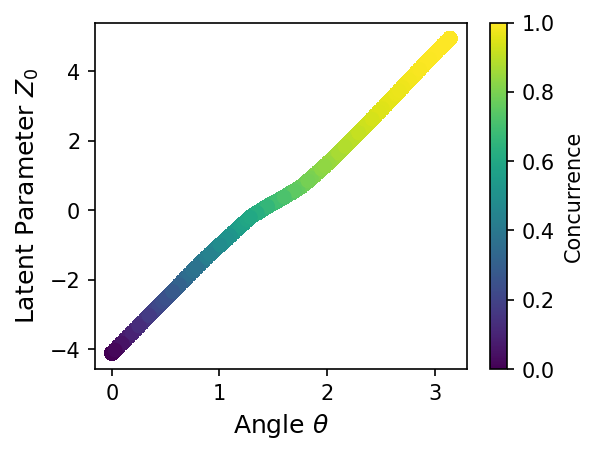

In [6]:
plot_scatter(y_test,z_mean[:,0],concurrence_arr,"Angle $\\theta$","Latent Parameter $Z_0$","Concurrence",1)

# Noisy Dataset  $\beta = 0$

Load Dataset

In [7]:
n_angle = 101
n_samples = 1000
rho_arr = np.load('unitary_4x4_101_1000.npy', mmap_mode="r")
scan_arr = np.linspace(0, np.pi, n_angle)

alpha_arr = np.zeros(len(rho_arr))
cnt = 0
for theta in scan_arr:
        for _ in (range(n_samples)):
            alpha_arr[cnt] = theta
            cnt += 1


X_train, X_test, y_train, y_test = train_test_split(rho_arr, alpha_arr, random_state=42)
concurrence_arr = np.array([qt.concurrence(qt.Qobj(dm.reshape(4,4),dims=[[2,2],[2,2]])) for dm in X_test])

Define Hyperparameters:

In [8]:
batch_size = 64
beta = 0.0
learning_rate = 0.005
lat_dim = 1
hidden_act = "tanh"
final_act = "linear"

Load trained VAE:

In [9]:
encoder, decoder = vae_mlp_4x4(lat_dim, hidden_act, final_act)

encoder.load_weights("encoder_noise_0beta.h5")
decoder.load_weights("decoder_noise_0beta.h5")

vae = VAE(encoder, decoder, beta)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
vae.fit(X_test, epochs=1, batch_size=64, verbose=1) 

z_mean, z_log_var, z = vae.encoder.predict(X_test)

790/790 [==============================] - 0s 430us/step


Investigate Latent Space

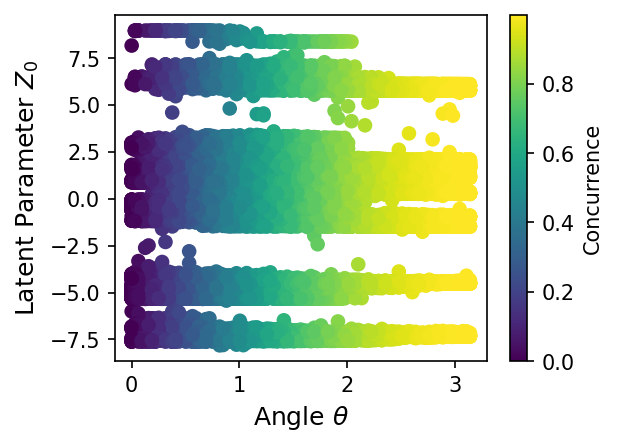

In [10]:
plot_scatter(y_test,z_mean[:,0],concurrence_arr,"Angle $\\theta$","Latent Parameter $Z_0$","Concurrence",1)

# Noisy Dataset  $0.75\beta$

Load Dataset

In [2]:
n_angle = 101
n_samples = 1000
rho_arr = np.load('unitary_4x4_101_1000.npy', mmap_mode="r")
scan_arr = np.linspace(0, np.pi, n_angle)

alpha_arr = np.zeros(len(rho_arr))
cnt = 0
for theta in scan_arr:
        for _ in (range(n_samples)):
            alpha_arr[cnt] = theta
            cnt += 1


X_train, X_test, y_train, y_test = train_test_split(rho_arr, alpha_arr, random_state=42)
concurrence_arr = np.array([qt.concurrence(qt.Qobj(dm.reshape(4,4),dims=[[2,2],[2,2]])) for dm in X_test])

In [8]:
rr_arr = np.array([qt.entropy_vn(qt.Qobj(dm.reshape(4,4),dims=[[2,2],[2,2]]).ptrace(0)) for dm in X_test])

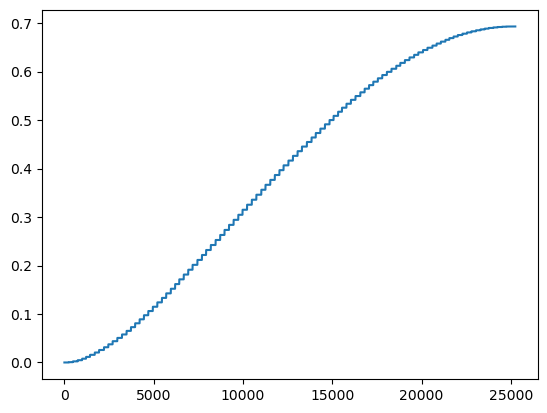

In [10]:
sort_inx = np.argsort(y_test)
plt.plot(rr_arr[sort_inx])

Define Hyperparameters:

In [3]:
batch_size = 64
beta = 0.75
learning_rate = 0.005
lat_dim = 1
hidden_act = "tanh"
final_act = "linear"

Load trained VAE:

In [4]:
encoder, decoder = vae_mlp_4x4(lat_dim, hidden_act, final_act)

encoder.load_weights("encoder_noise_075beta.h5")
decoder.load_weights("decoder_noise_075beta.h5")

vae = VAE(encoder, decoder, beta)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
vae.fit(X_test[:2], epochs=1, batch_size=64, verbose=1) 

z_mean, z_log_var, z = vae.encoder.predict(X_test)

2023-03-24 10:36:05.263371: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-24 10:36:05.263389: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-24 10:36:05.263401: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (felix-Latitude-5521): /proc/driver/nvidia/version does not exist
2023-03-24 10:36:05.263557: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


790/790 [==============================] - 0s 518us/step


Investigate Latent Space

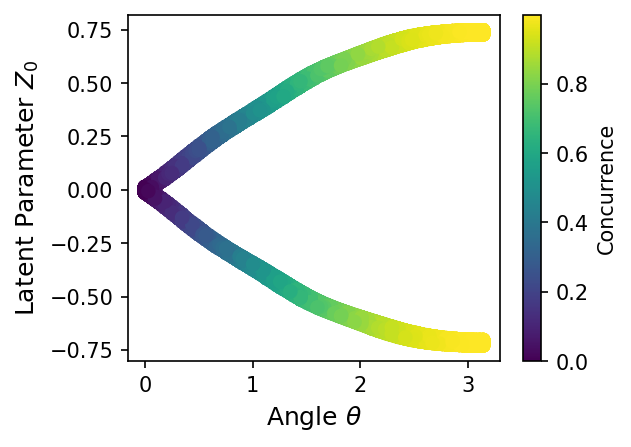

In [5]:
plot_scatter(y_test,z_mean[:,0],concurrence_arr,"Angle $\\theta$","Latent Parameter $Z_0$","Concurrence",1)

Investigate generalization and relation to concurrence 


In [6]:
rho_arr_noiseless = np.load('unitary_4x4_101_1000_noiseless.npy', mmap_mode="r")
_, X_test_noiseless, _, y_test_noiseless = train_test_split(rho_arr_noiseless, alpha_arr, random_state=42)
z_mean_noiseless, _, _ = vae.encoder.predict(X_test_noiseless)

790/790 [==============================] - 0s 531us/step


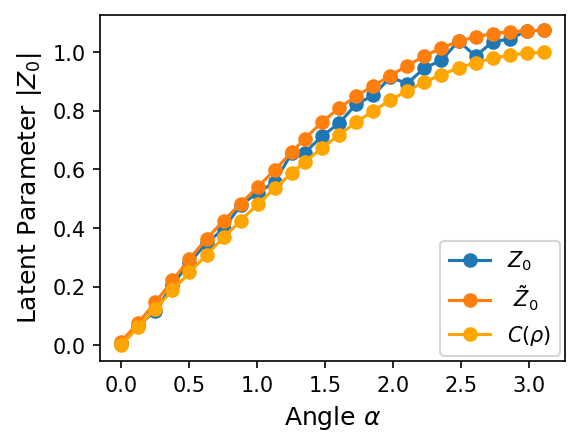

In [20]:
fig, ax = plt.subplots(figsize=(4, 3),dpi=150)

sort_inx = np.argsort(y_test)

ax.plot(y_test[sort_inx][::1000], np.abs(z_mean[sort_inx][:,0][::1000])/np.log(2),"-o", label="$Z_0$") 
ax.plot(y_test[sort_inx][::1000], z_mean_noiseless[sort_inx][:,0][::1000]/np.log(2),"-o", label=" $\\tilde{Z}_0$") 


ax.plot(y_test[sort_inx][::1000],concurrence_arr[sort_inx][::1000],"-o",c="orange", label= "$C(\\rho)$")

# ax.plot(y_test[sort_inx][::1000],rr_arr[sort_inx][::1000],"-o",c="orange", label= "$C(\\rho)$")


# ax2 = ax.twinx()

# ax2.plot(y_test[sort_inx][::1000],concurrence_arr[sort_inx][::1000],"-o",c="orange", label= "$C(\\rho)$")

ax.set_ylabel("Latent Parameter $|Z_0|$",fontsize=12)
ax.set_xlabel("Angle $\\alpha$",fontsize=12)
ax2.set_ylabel("Concurrence",fontsize=12)

fig.legend(bbox_to_anchor=(0.675, 0.4), loc=2)

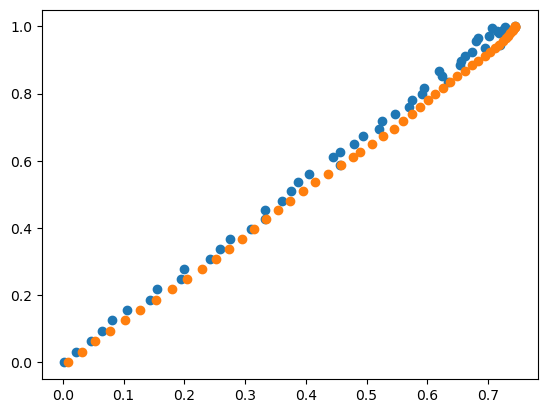

In [24]:
plt.scatter(np.abs(z_mean[sort_inx][:,0][::500]),concurrence_arr[sort_inx][::500])

plt.scatter(np.abs(z_mean_noiseless[sort_inx][:,0][::500]),concurrence_arr[sort_inx][::500])


In [8]:
rho_arr_deco = np.load('unitary_4x4_101_1000_deco_01.npy', mmap_mode="r")
_, X_test_deco, _, y_test_deco = train_test_split(rho_arr_deco, alpha_arr, random_state=42)
z_mean_deco, _, _ = vae.encoder.predict(X_test_deco)

concurrence_deco_arr = np.array([qt.concurrence(qt.Qobj(dm.reshape(4,4),dims=[[2,2],[2,2]])) for dm in X_test_deco])

790/790 [==============================] - 1s 647us/step


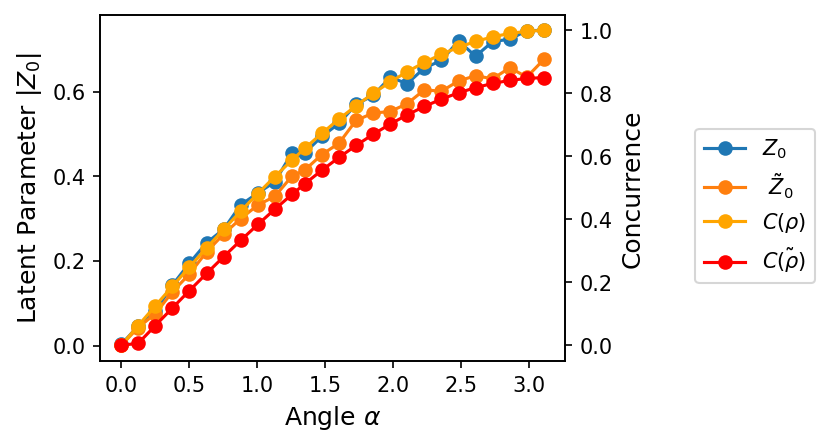

In [9]:
fig, ax = plt.subplots(figsize=(4, 3),dpi=150)

sort_inx = np.argsort(y_test)

ax.plot(y_test[sort_inx][::1000], np.abs(z_mean[sort_inx][:,0][::1000]),"-o", label="$Z_0$") 
ax.plot(y_test[sort_inx][::1000], np.abs(z_mean_deco[sort_inx][:,0][::1000]),"-o", label=" $\\tilde{Z}_0$") 


ax2 = ax.twinx()

ax2.plot(y_test[sort_inx][::1000],concurrence_arr[sort_inx][::1000],"-o",c="orange", label= "$C(\\rho)$")
ax2.plot(y_test[sort_inx][::1000],concurrence_deco_arr[sort_inx][::1000],"-o", c="red",label= "$\\tilde{C(\\rho)}$")


ax.set_ylabel("Latent Parameter $|Z_0|$",fontsize=12)
ax.set_xlabel("Angle $\\alpha$",fontsize=12)
ax2.set_ylabel("Concurrence",fontsize=12)

fig.legend(bbox_to_anchor=(1.1, 0.65), loc=2)

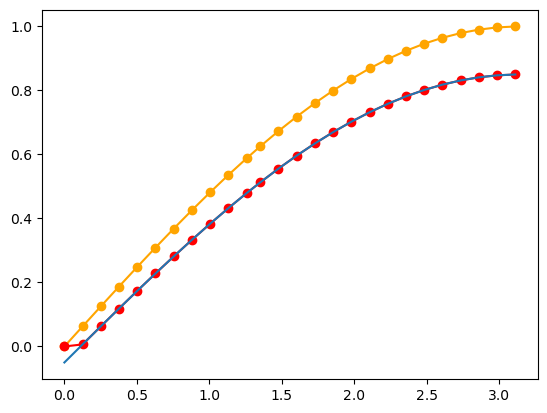

In [11]:
plt.plot(y_test[sort_inx][::1000],concurrence_arr[sort_inx][::1000],"-o",c="orange", label= "$C(\\rho)$")
plt.plot(y_test[sort_inx][::1000],concurrence_deco_arr[sort_inx][::1000],"-o", c="red",label= "$\\tilde{C(\\rho)}$")
plt.plot(y_test[sort_inx][::1000],(0.9)*concurrence_arr[sort_inx][::1000]-0.05)

In [60]:
rr_arr = np.array([qt.entropy_vn(qt.Qobj(dm.reshape(4,4),dims=[[2,2],[2,2]]).ptrace(1)) for dm in rho_gamma])

In [63]:
dm = rho_gamma[-1]
qt.Qobj(dm.reshape(4,4),dims=[[2,2],[2,2]])

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.16666667  0.          0.         -0.16666667]
 [ 0.          0.33333333  0.          0.        ]
 [ 0.          0.          0.33333333  0.        ]
 [-0.16666667  0.          0.          0.16666667]]

In [87]:
gamma = np.load('/home/felix/Downloads/gamma_new.npy', mmap_mode="r")
rho_gamma = np.load('/home/felix/Downloads/rho_gamma_noiseless.npy', mmap_mode="r")

z_mean_gamma, _, _ = vae.encoder.predict(rho_gamma)

4/4 [==============================] - 0s 2ms/step


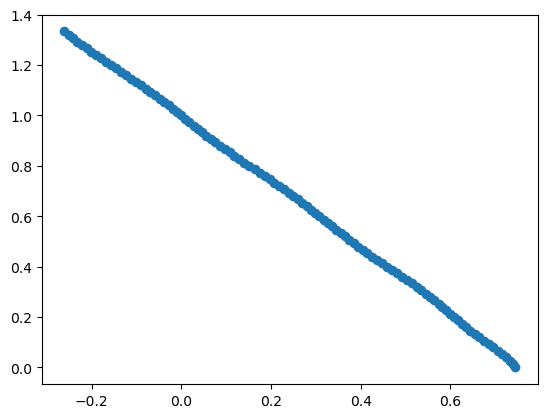

In [88]:
plt.scatter(z_mean_gamma,gamma)

In [97]:
offset = 1-z_mean_gamma.flatten()[0]

In [115]:
test = (1-gamma)*z_mean_gamma.flatten() #+ gamma/2

In [124]:
test = z_mean_gamma.flatten()*2 + (1-z_mean_gamma.flatten()[0]*2)

In [135]:


for i in range(len(test)):
    print(np.round(test[i],2),conc[i])

1.0 0.9999999999999998
0.99 0.9800000000000098
0.97 0.9599999999999999
0.96 0.9400000000000008
0.94 0.9199999999999998
0.92 0.8999999999999997
0.9 0.8799999999999986
0.88 0.86
0.86 0.84
0.84 0.8200000000000003
0.82 0.8000000000000004
0.8 0.7800000000000002
0.78 0.759999999999999
0.76 0.7400000000000002
0.74 0.7199999999999995
0.73 0.7000000000000002
0.71 0.6799999999999999
0.69 0.6599999999999998
0.68 0.64
0.66 0.62
0.64 0.6000000000000001
0.62 0.5799999999999998
0.6 0.5600000000000004
0.58 0.5400000000000001
0.56 0.5199999999999998
0.54 0.4999999999999999
0.52 0.4799999999999994
0.49 0.45999999999999974
0.47 0.4399999999999998
0.45 0.4199999999999998
0.43 0.40000000000000024
0.4 0.38
0.38 0.35999999999999976
0.36 0.34000000000000025
0.34 0.3199999999999999
0.32 0.3000000000000002
0.3 0.2799999999999998
0.28 0.2599999999999999
0.26 0.23999999999999994
0.24 0.21999999999999975
0.22 0.19999999999999982
0.2 0.18
0.18 0.15999999999999998
0.16 0.14
0.15 0.11999999999999983
0.13 0.0999999999

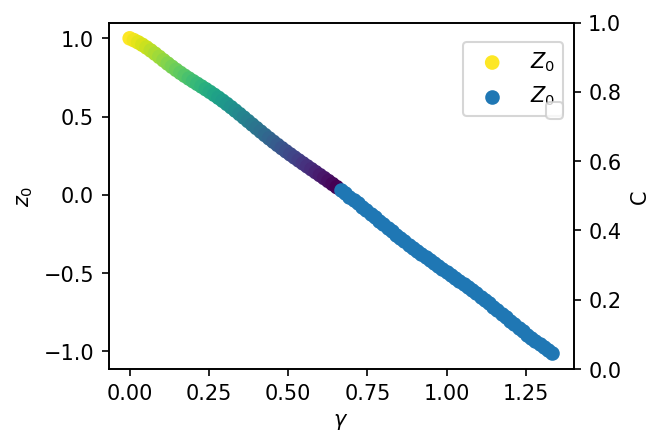

In [131]:
fig, ax = plt.subplots(figsize=(4, 3),dpi=150)

sort_inx = np.argsort(y_test)

# ax.plot(gamma,np.max(test),"-o", label="$Z_0$") 
conc = np.array([qt.concurrence(qt.Qobj(dm.reshape(4,4),dims=[[2,2],[2,2]])) for dm in rho_gamma])

inx_1 = conc>0
inx_2 = conc==0

ax.scatter(gamma[inx_1], test[inx_1], c=conc[inx_1], label="$Z_0$") 
ax.scatter(gamma[inx_2], test[inx_2], label="$Z_0$") 



ax2 = ax.twinx()
# ax.plot(gamma,np.array([qt.concurrence(qt.Qobj(dm.reshape(4,4),dims=[[2,2],[2,2]])) for dm in rho_gamma]),"-o", label=" $C$",c="orange") 

# ax.plot(gamma,rr_arr,"-o", label=" $C$",c="orange") 


ax.set_xlabel("$\\gamma$")
ax.set_ylabel("$z_0$")
ax2.set_ylabel("C")
ax.legend(bbox_to_anchor=(1.0, 0.975))
ax2.legend(bbox_to_anchor=(1.0, 0.8))


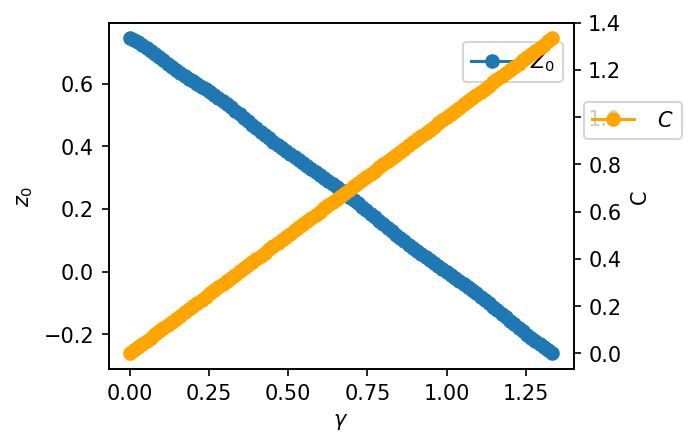

In [46]:
fig, ax = plt.subplots(figsize=(4, 3),dpi=150)

sort_inx = np.argsort(y_test)

ax.plot(gamma,z_mean_gamma,"-o", label="$Z_0$") 


ax2 = ax.twinx()
ax2.plot(gamma,gamma,"-o", label=" $C$",c="orange") 

ax.set_xlabel("$\\gamma$")
ax.set_ylabel("$z_0$")
ax2.set_ylabel("C")
ax.legend(bbox_to_anchor=(1.0, 0.975))
ax2.legend(bbox_to_anchor=(1.0, 0.8))


# Multiple Experiments

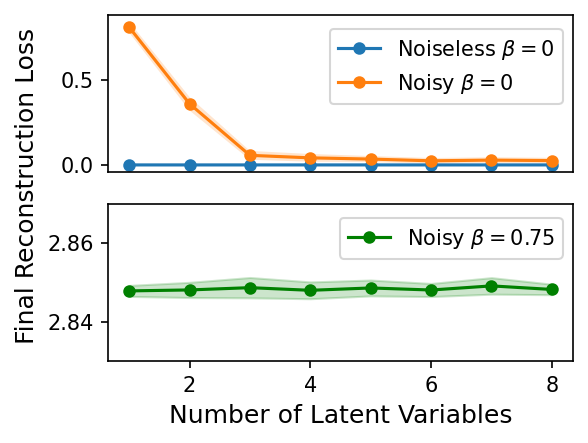

In [55]:
lat_arr = np.arange(1,9)
n_exp = 9


recon_loss_noiseless = np.zeros((len(lat_arr),n_exp, 1))
recon_loss_noise = np.zeros((len(lat_arr),n_exp, 1))
recon_loss_noise_075 = np.zeros((len(lat_arr),n_exp, 1))


for cnt_1, inx in enumerate(lat_arr):
    for cnt_2 in range(n_exp):
        read_dictionary = np.load('no_0beta_latent/history_{}_1_{}.npy'.format(inx,cnt_2),allow_pickle='TRUE').item()
        recon_loss_noiseless[cnt_1][cnt_2] = read_dictionary["reconstruction_loss"][-1]
        
        read_dictionary = np.load('noise_0beta_latent/history_{}_1_{}.npy'.format(inx,cnt_2),allow_pickle='TRUE').item()
        recon_loss_noise[cnt_1][cnt_2] = read_dictionary["reconstruction_loss"][-1]
        
        read_dictionary = np.load('noise_075beta_latent/history_{}_1_{}.npy'.format(inx,cnt_2),allow_pickle='TRUE').item()
        recon_loss_noise_075[cnt_1][cnt_2] = read_dictionary["reconstruction_loss"][-1]

av_recon_loss_arr_noiseless = np.average(recon_loss_noiseless,axis=1)
std_recon_loss_arr_noiseless = np.std(recon_loss_noiseless,axis=1)

av_recon_loss_arr_noise = np.average(recon_loss_noise,axis=1)
std_recon_loss_arr_noise = np.std(recon_loss_noise,axis=1)

av_recon_loss_arr_noise_075 = np.average(recon_loss_noise_075,axis=1)
std_recon_loss_arr_noise_075 = np.std(recon_loss_noise_075,axis=1)

fig, ax = plt.subplots(2,1,figsize=(4, 3),dpi=150)


ax[0].plot(lat_arr, av_recon_loss_arr_noiseless, marker='o', markersize="5",label="Noiseless $\\beta=0$")
ax[0].fill_between(lat_arr, (av_recon_loss_arr_noiseless - std_recon_loss_arr_noiseless).flatten(), (av_recon_loss_arr_noiseless + std_recon_loss_arr_noiseless).flatten(), alpha=0.2)

ax[0].plot(lat_arr, av_recon_loss_arr_noise, marker='o', markersize="5",label="Noisy $\\beta=0$")
ax[0].fill_between(lat_arr, (av_recon_loss_arr_noise - std_recon_loss_arr_noise).flatten(), (av_recon_loss_arr_noise + std_recon_loss_arr_noise).flatten(), alpha=0.2)

ax[1].plot(lat_arr, av_recon_loss_arr_noise_075, marker='o', markersize="5",label="Noisy $\\beta=0.75$",c="green")
ax[1].fill_between(lat_arr, (av_recon_loss_arr_noise_075 - std_recon_loss_arr_noise_075).flatten(), (av_recon_loss_arr_noise_075 + std_recon_loss_arr_noise_075).flatten(), alpha=0.2,color="green")


ax[1].set_xlabel("Number of Latent Variables",fontsize=12)
# ax[0].set_ylabel("Final Reconstruction Loss",fontsize=12)

ax[0].set_xticks([])

ax[1].set_ylim([2.83,2.87])

# fig.legend(bbox_to_anchor=(0.9, 0.88))

ax[0].legend(bbox_to_anchor=(1.0, 0.975))
ax[1].legend(bbox_to_anchor=(1.0, 0.975))

fig.text(-0.03, 0.5, 'Final Reconstruction Loss', va='center', rotation='vertical',fontsize=12)
plt.show()

# Beta Scan

In [29]:
def kl_loss(mu,sig):
    return -0.5 * (1 + sig - mu**2 - np.exp(sig))

In [4]:
n_angle = 101
n_samples = 1000
rho_arr = np.load('unitary_4x4_101_1000.npy', mmap_mode="r")
scan_arr = np.linspace(0, np.pi, n_angle)

alpha_arr = np.zeros(len(rho_arr))
cnt = 0
for theta in scan_arr:
        for _ in (range(n_samples)):
            alpha_arr[cnt] = theta
            cnt += 1


X_train, X_test, y_train, y_test = train_test_split(rho_arr, alpha_arr, random_state=42)
concurrence_arr = np.array([qt.concurrence(qt.Qobj(dm.reshape(4,4),dims=[[2,2],[2,2]])) for dm in X_test])

In [22]:
batch_size = 64
learning_rate = 0.005
lat_dim = 8
hidden_act = "tanh"
final_act = "linear"

In [23]:
inx_dict = {"001":0.01,"01":0.1,"02":0.2,"03":0.3,
            "04":0.4,"05":0.5,"06":0.6,"07":0.7,
            "08":0.8,"09":0.9,"10":1.0,"11":1.1, "12":1.2}

In [26]:
encoder, decoder = vae_mlp_4x4(lat_dim, hidden_act, final_act)

encoder.load_weights("grid_8/encoder_{}_grid_8.h5".format("06"))
decoder.load_weights("grid_8/decoder_{}_grid_8.h5".format("06"))

vae = VAE(encoder, decoder, beta)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
history_dict = vae.fit(X_test, epochs=1, batch_size=64, verbose=0) 

In [27]:
z_mean, z_log_var, z = vae.encoder.predict(X_test)

790/790 [==============================] - 1s 646us/step


In [30]:
for i in range(8):
        print(np.average(kl_loss(z_mean[:,i], z_log_var[:,i]))) 

0.00015728168
0.00026049095
4.6940336e-06
4.453617e-05
4.820446e-06
2.143877e-05
0.20096588
4.5776782e-05


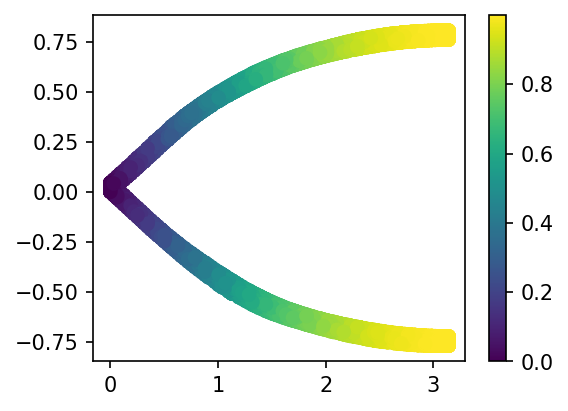

In [32]:
plot_scatter(y_test, z_mean[:,-2],concurrence_arr,"","","",1)

In [7]:
recon_loss_arr = np.zeros(len(inx_dict))
kl_loss_arr = np.zeros(len(inx_dict))
full_kl_loss_arr = np.zeros((len(inx_dict),8))

cnt = 0
for inx,beta in inx_dict.items():

    encoder, decoder = vae_mlp_4x4(lat_dim, hidden_act, final_act)

    encoder.load_weights("grid_8/encoder_{}_grid_8.h5".format(inx))
    decoder.load_weights("grid_8/decoder_{}_grid_8.h5".format(inx))

    vae = VAE(encoder, decoder, beta)
    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    history_dict = vae.fit(X_test, epochs=1, batch_size=64, verbose=0) 

    recon_loss_arr[cnt] = history_dict.history["reconstruction_loss"][0]
    kl_loss_arr[cnt] = history_dict.history["kl_loss"][0]
    
    
    z_mean, z_log_var, z = vae.encoder.predict(X_test)
    
    for i in range(8):
        full_kl_loss_arr[cnt][i] = np.average(kl_loss(z_mean[:,i], z_log_var[:,i]))
    cnt += 1 
    
    
    
#     plot_scatter(z_mean[:,0],z_mean[:,1],concurrence_arr,"$Z_0$","$Z_1$","",1)

2023-03-15 17:57:29.919330: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-15 17:57:29.919351: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-15 17:57:29.919388: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (felix-Latitude-5521): /proc/driver/nvidia/version does not exist
2023-03-15 17:57:29.919599: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


790/790 [==============================] - 1s 628us/step


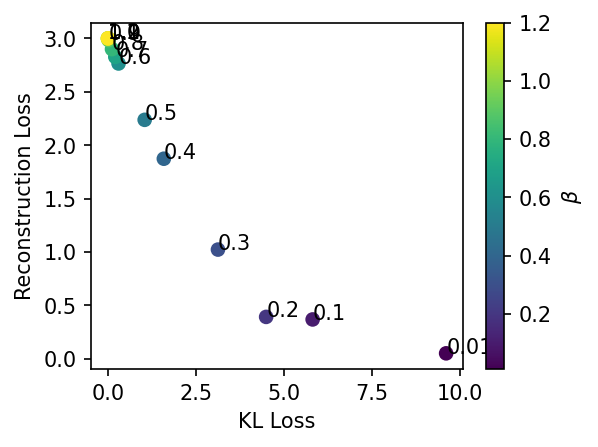

In [8]:
fig, ax = plt.subplots(figsize=(4, 3),dpi=150)
im = ax.scatter(kl_loss_arr, recon_loss_arr, c=list(inx_dict.values()))
cbar = fig.colorbar(im)
cbar.set_label("$\\beta$")
plt.xlabel("KL Loss")
plt.ylabel("Reconstruction Loss")


for i, txt in enumerate(inx_dict.values()):
    ax.annotate(txt, (kl_loss_arr[i], recon_loss_arr[i]))

plt.show()

In [12]:
["$Z_{7}$","$Z_{6}$","$Z_{5}$","$Z_{4}$","$Z_{3}$","$Z_{2}$","$Z_{1}$","$Z_{0}$"]

beta_list = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2]

In [17]:
new_matrix




(13, 8)

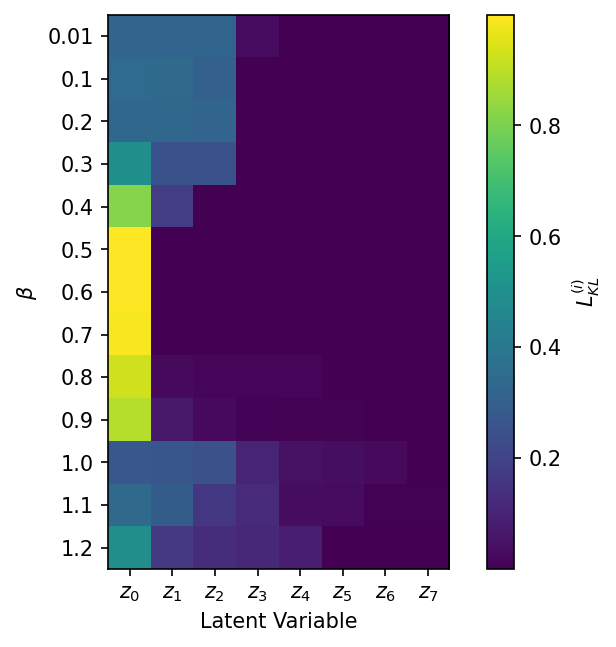

In [37]:
row_sums = np.sort(full_kl_loss_arr,axis=-1).sum(axis=1)
new_matrix = np.sort(full_kl_loss_arr,axis=-1) / row_sums[:, np.newaxis]

fig, ax = plt.subplots(dpi=150)
im = ax.imshow(np.flip(new_matrix,axis=1))
cbar = fig.colorbar(im)
cbar.set_label("$L_{KL}^{(i)}$")
plt.xticks(range(8),["$z_{}$".format(i) for i in range(lat_dim)])
plt.yticks(range(len(inx_dict)),beta_list)

plt.xlabel("Latent Variable")
plt.ylabel("$\\beta$")

plt.show()

# 3 LV with ramp

In [8]:
batch_size = 64
beta = 0.75
learning_rate = 0.005
lat_dim = 3
hidden_act = "tanh"
final_act = "linear"

In [9]:
encoder, decoder = vae_mlp_4x4(lat_dim, hidden_act, final_act)

encoder.load_weights("/home/felix/Downloads/vae/encoder_3lv_0beta_ramp.h5")
decoder.load_weights("/home/felix/Downloads/vae/decoder_3lv_0beta_ramp.h5")

vae = VAE(encoder, decoder, beta)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
vae.fit(X_test[:2], epochs=1, batch_size=64, verbose=1) 

z_mean, z_log_var, z = vae.encoder.predict(X_test)

790/790 [==============================] - 0s 542us/step


<IPython.core.display.Javascript object>


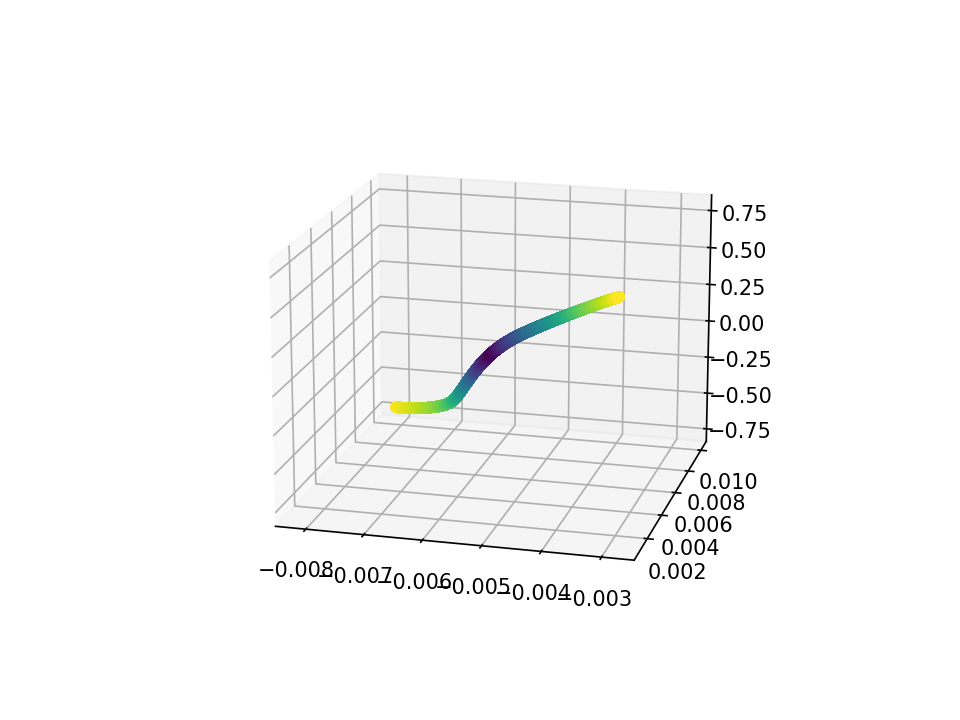

In [10]:
fig = plt.figure(dpi = 150)
ax = fig.add_subplot(projection='3d')
ax.scatter(z_mean[:,0], z_mean[:,1],z_mean[:,2], c=concurrence_arr,alpha=1)

<IPython.core.display.Javascript object>


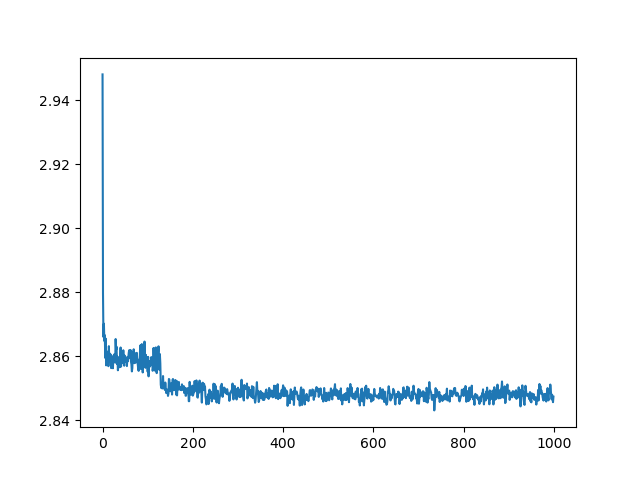

In [16]:
read_dictionary = np.load('/home/felix/Downloads/vae/history_3lv_0beta_ramp.npy',allow_pickle='TRUE').item()
plt.plot(read_dictionary["reconstruction_loss"])
        

# 3 LV with ramp

In [2]:
batch_size = 64
beta = 0.0
learning_rate = 0.005
lat_dim = 3
hidden_act = "tanh"
final_act = "linear"

In [6]:
encoder, decoder = vae_mlp_4x4(lat_dim, hidden_act, final_act)

encoder.load_weights("/home/felix/Downloads/vae/encoder_3lv_00beta_ramp.h5")
decoder.load_weights("/home/felix/Downloads/vae/decoder_3lv_00beta_ramp.h5")

vae = VAE(encoder, decoder, beta)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
vae.fit(X_test[:2], epochs=1, batch_size=64, verbose=1) 

z_mean, z_log_var, z = vae.encoder.predict(X_test)

790/790 [==============================] - 1s 654us/step


In [ ]:
plot_scatter(y_test,z_mean[:,1],concurrence_arr,"Angle $\\theta$","Latent Parameter $Z_0$","Concurrence",1)

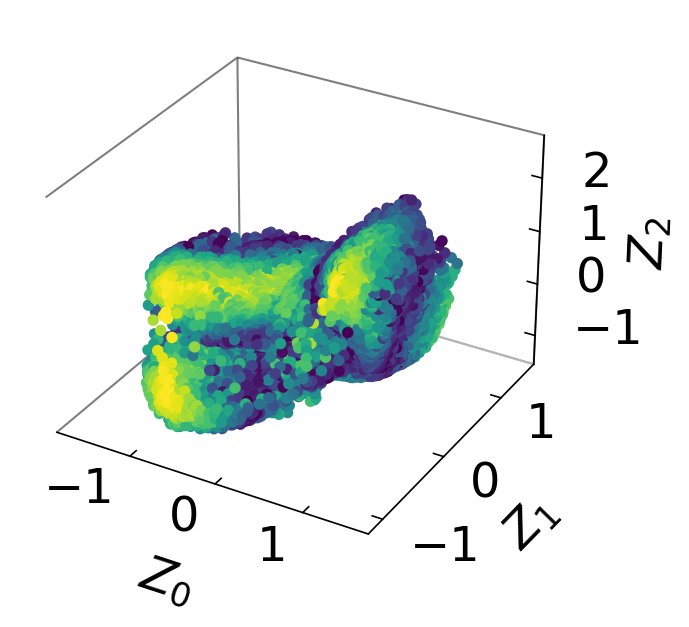

In [25]:
from matplotlib import rc
from matplotlib.ticker import MultipleLocator 


fig = plt.figure(dpi = 150)
ax = fig.add_subplot(projection='3d')
ax.scatter(z_mean[:,0], z_mean[:,1],z_mean[:,2], c=concurrence_arr,alpha=1)

ax.set_xlabel("\n$Z_0$")
ax.set_ylabel("\n$Z_1$")
ax.set_zlabel("\n$Z_2$")

rc('font',size=23)
# rc('font',family='serif')
rc('axes',labelsize=23)

[t.set_va('center') for t in ax.get_yticklabels()]
[t.set_ha('left') for t in ax.get_yticklabels()]
[t.set_va('center') for t in ax.get_xticklabels()]
[t.set_ha('right') for t in ax.get_xticklabels()]
[t.set_va('center') for t in ax.get_zticklabels()]
[t.set_ha('left') for t in ax.get_zticklabels()]

ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.xaxis._axinfo['tick']['inward_factor'] = 0
ax.xaxis._axinfo['tick']['outward_factor'] = 0.4
ax.yaxis._axinfo['tick']['inward_factor'] = 0
ax.yaxis._axinfo['tick']['outward_factor'] = 0.4
ax.zaxis._axinfo['tick']['inward_factor'] = 0
ax.zaxis._axinfo['tick']['outward_factor'] = 0.4
ax.zaxis._axinfo['tick']['outward_factor'] = 0.4

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.zaxis.set_major_locator(MultipleLocator(1))
# ax.dist = 8

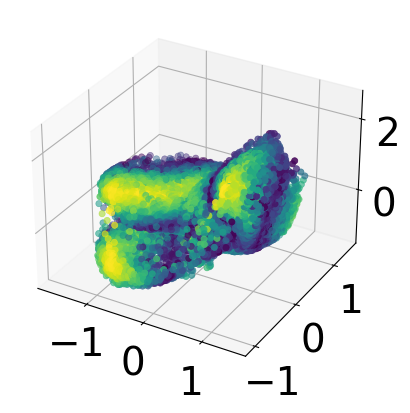

In [9]:
ax = plt.axes(projection='3d')
ax.scatter(z_mean[:,0], z_mean[:,1],z_mean[:,2], c=concurrence_arr, linewidth=0.5);

/home/felix/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felix/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<IPython.core.display.Javascript object>


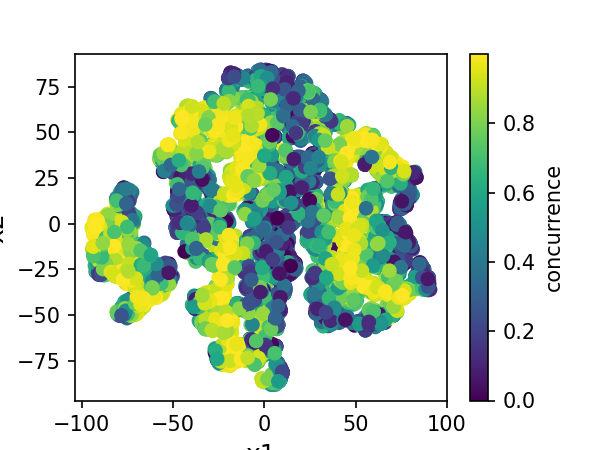

In [21]:
tsne = TSNE()
X_embedded = tsne.fit_transform(z_mean[:10000])
plot_scatter(X_embedded[:,0], X_embedded[:,1] , concurrence_arr[:10000],"x1","x2","concurrence", 1)

# 3 LV without ramp

In [101]:
batch_size = 64
beta = 0.00
learning_rate = 0.005
lat_dim = 3
hidden_act = "tanh"
final_act = "linear"

In [145]:
encoder, decoder = vae_mlp_4x4(lat_dim, hidden_act, final_act)

encoder.load_weights("/home/felix/Downloads/vae/encoder_3lv_00beta_noramp.h5")
decoder.load_weights("/home/felix/Downloads/vae/decoder_3lv_00beta_noramp.h5")

vae = VAE(encoder, decoder, beta)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
vae.fit(X_test[:2], epochs=1, batch_size=64, verbose=1) 

z_mean, z_log_var, z = vae.encoder.predict(X_test)

790/790 [==============================] - 0s 496us/step


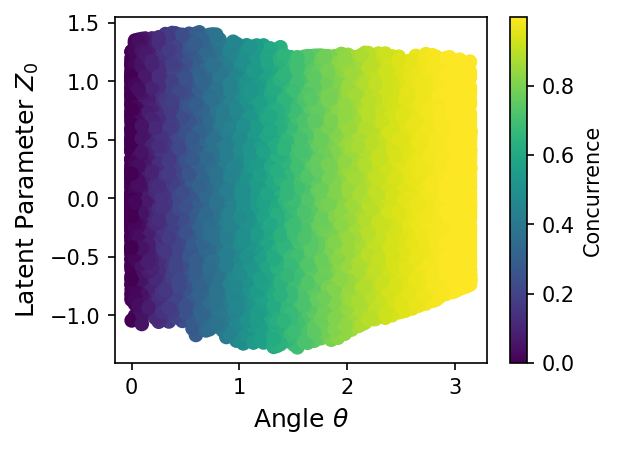

In [146]:
plot_scatter(y_test,z_mean[:,1],concurrence_arr,"Angle $\\theta$","Latent Parameter $Z_0$","Concurrence",1)

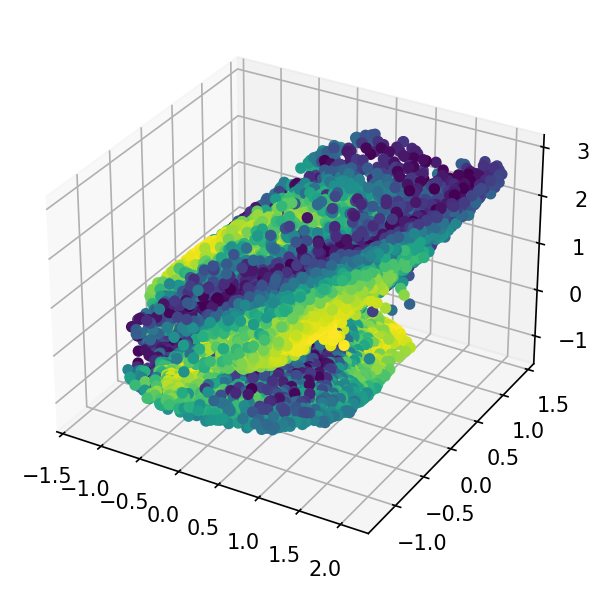

In [147]:
fig = plt.figure(dpi = 150)
ax = fig.add_subplot(projection='3d')
ax.scatter(z_mean[:,0], z_mean[:,1],z_mean[:,2], c=concurrence_arr,alpha=1)

# 8 LV with ramp

In [125]:
batch_size = 64
beta = 0.0
learning_rate = 0.005
lat_dim = 8
hidden_act = "tanh"
final_act = "linear"

In [138]:
encoder, decoder = vae_mlp_4x4(lat_dim, hidden_act, final_act)

encoder.load_weights("/home/felix/Downloads/vae/encoder_8lv_00beta_ramp.h5")
decoder.load_weights("/home/felix/Downloads/vae/decoder_8lv_00beta_ramp.h5")

vae = VAE(encoder, decoder, beta)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
vae.fit(X_test[:2], epochs=1, batch_size=64, verbose=1) 

z_mean, z_log_var, z = vae.encoder.predict(X_test)

790/790 [==============================] - 0s 529us/step


/home/felix/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/felix/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


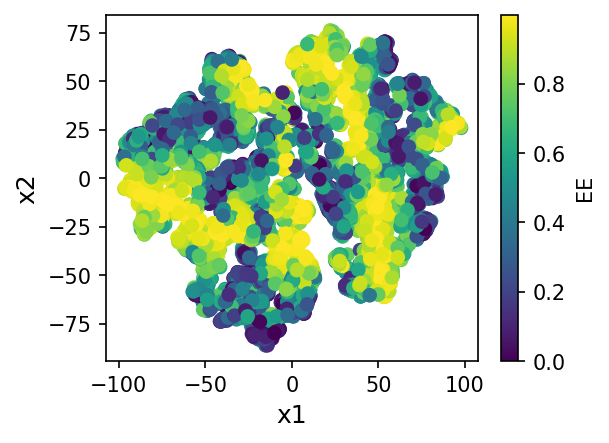

In [140]:
tsne = TSNE()
X_embedded = tsne.fit_transform(z_mean[:10000])
plot_scatter(X_embedded[:,0], X_embedded[:,1] , concurrence_arr[:10000],"x1","x2","concurrence", 1)

# 8 LV without ramp

In [133]:
batch_size = 64
beta = 0.0
learning_rate = 0.005
lat_dim = 8
hidden_act = "tanh"
final_act = "linear"

In [134]:
encoder, decoder = vae_mlp_4x4(lat_dim, hidden_act, final_act)

encoder.load_weights("/home/felix/Downloads/vae/encoder_8lv_00beta_noramp.h5")
decoder.load_weights("/home/felix/Downloads/vae/decoder_8lv_00beta_noramp.h5")

vae = VAE(encoder, decoder, beta)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
vae.fit(X_test[:2], epochs=1, batch_size=64, verbose=1) 

z_mean, z_log_var, z = vae.encoder.predict(X_test)

790/790 [==============================] - 0s 534us/step


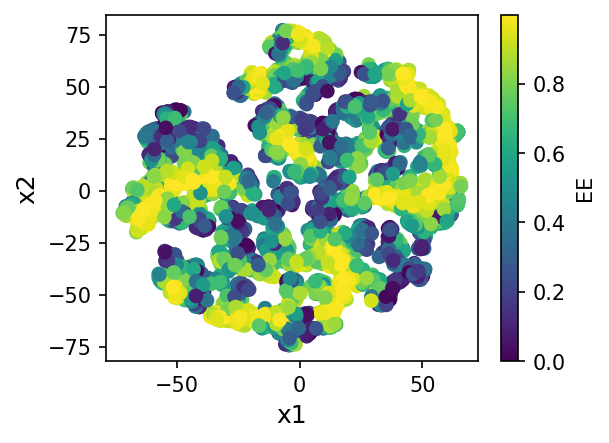

In [136]:
tsne = TSNE()
X_embedded = tsne.fit_transform(z_mean[:5000])
plot_scatter(X_embedded[:,0], X_embedded[:,1] , concurrence_arr[:5000],"x1","x2","EE", 1)